In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import os

In [ ]:
print(os.listdir("/content/drive/MyDrive/Kidney Cancer"))

['Tumor', 'Normal']


In [ ]:
DATADIR = "/content/drive/MyDrive/Kidney Cancer"

CATEGORIES = ["Normal","Tumor"]

In [ ]:
IMG_SIZE = 100

In [ ]:
all_data = []

def create_all_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                all_data.append([new_array, class_num])
            except Exception as e:
                pass

create_all_data()

In [ ]:
print("Toplam Görüntü Sayısı: ", len(all_data))

Toplam Görüntü Sayısı:  10000


In [ ]:
X = []
y = []

for categories, label in all_data:
  X.append(categories)
  y.append(label)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state =42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(5850, 100, 100)
(3500, 100, 100)
(650, 100, 100)
(5850,)
(3500,)
(650,)


In [ ]:
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

x_train = np.repeat(x_train, 3, axis=-1)
x_val = np.repeat(x_val, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)

In [ ]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

In [ ]:
import tensorflow as tf

train_yCl = tf.keras.utils.to_categorical(y_train, num_classes=2)
test_yCl = tf.keras.utils.to_categorical(y_test, num_classes=2)
valid_yCl = tf.keras.utils.to_categorical(y_val, num_classes=2)

In [ ]:
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

In [ ]:
res = tf.keras.applications.ResNet50V2(
    input_shape=(100, 100, 3),
    include_top = False
)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
res_model = Sequential()
res_model.add(res)
res_model.add(Dropout(0.25))
res_model.add(MaxPooling2D())
res_model.add(Flatten())
res_model.add(Dense(256, activation='relu'))
res_model.add(BatchNormalization())
res_model.add(Dropout(0.5))
res_model.add(Dense(2, activation='softmax'))

In [ ]:
res_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = res_model.fit(x_train, train_yCl,
                        batch_size=120,
                        epochs=10,
                        validation_data=(x_val, valid_yCl))

Epoch 1/10
49/49 [==============================] - 1105s 22s/step - loss: 0.1509 - accuracy: 0.9533 - val_loss: 4.6627 - val_accuracy: 0.7477
Epoch 2/10
49/49 [==============================] - 1088s 22s/step - loss: 0.0116 - accuracy: 0.9962 - val_loss: 2.0676 - val_accuracy: 0.8369
Epoch 3/10
49/49 [==============================] - 1066s 22s/step - loss: 0.0093 - accuracy: 0.9964 - val_loss: 0.1080 - val_accuracy: 0.9846
Epoch 4/10
49/49 [==============================] - 1065s 22s/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0131 - val_accuracy: 0.9969
Epoch 5/10
49/49 [==============================] - 1055s 22s/step - loss: 0.0083 - accuracy: 0.9971 - val_loss: 0.0496 - val_accuracy: 0.9954
Epoch 6/10
49/49 [==============================] - 1067s 22s/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 5.6435e-05 - val_accuracy: 1.0000
Epoch 7/10
49/49 [==============================] - 1069s 22s/step - loss: 9.4533e-04 - accuracy: 0.9995 - val_loss: 0.0355 - val_accuracy

In [ ]:
score_valid = res_model.evaluate(x_val, valid_yCl)
print("Validation Accuracy: ", score_valid[1])

score_test = res_model.evaluate(x_test, test_yCl)
print("Test Accuracy: ", score_test[1])

score_train = res_model.evaluate(x_train, train_yCl)
print("Train Accuracy: ",score_train[1])

21/21 [==============================] - 23s 1s/step - loss: 0.0011 - accuracy: 1.0000
Validation Accuracy:  1.0
110/110 [==============================] - 121s 1s/step - loss: 0.0024 - accuracy: 0.9989
Test Accuracy:  0.9988571405410767
183/183 [==============================] - 194s 1s/step - loss: 0.0013 - accuracy: 0.9997
Train Accuracy:  0.9996581077575684


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Test verisi üzerinde tahminlerde bulunun
y_pred_probs = res_model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Gerçek sınıfları alın
y_true_classes = np.argmax(test_yCl, axis=1)

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Recall: {recall}")

# F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"F1-Score: {f1}")

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

110/110 [==============================] - 130s 1s/step
Accuracy: 0.9988571428571429
Precision: 0.9988598037585231
Recall: 0.9988571428571429
F1-Score: 0.9988571682428183
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1786
           1       1.00      1.00      1.00      1714

    accuracy                           1.00      3500
   macro avg       1.00      1.00      1.00      3500
weighted avg       1.00      1.00      1.00      3500

Confusion Matrix:
[[1782    4]
 [   0 1714]]


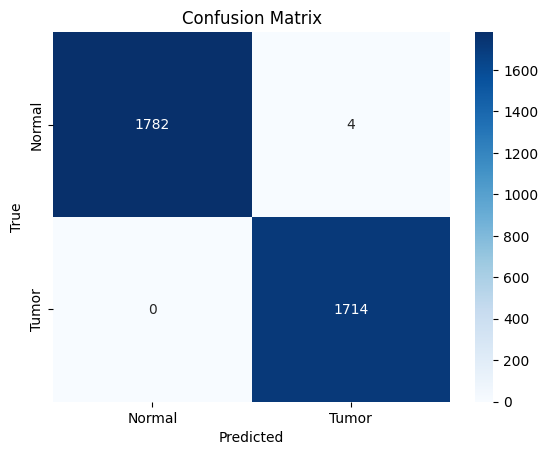

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()